In [1]:
import ast, cv2, re, sys
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from pytesseract import Output
from pathlib import Path
from matplotlib import rcParams

In [2]:
img_dir = 'test'
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

## Image into data and filter text.

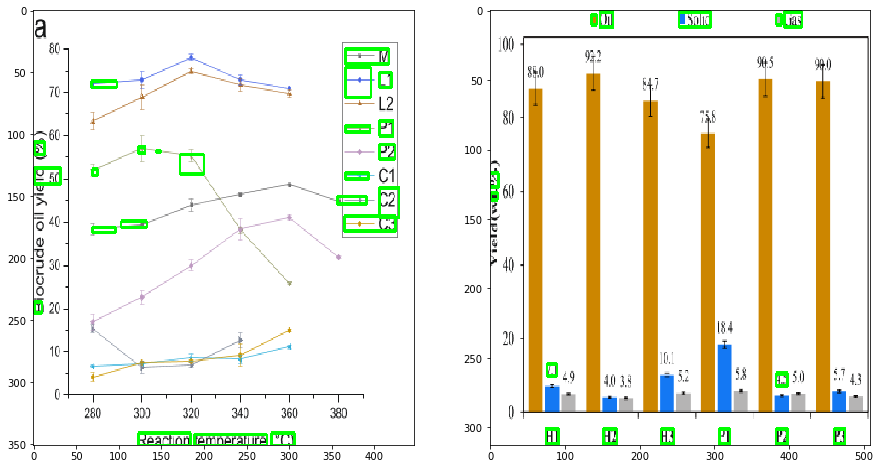

In [3]:
images = []
texts = []

for path in Path(img_dir).iterdir():
    if path.name.endswith('.png') or path.name.endswith('.jpg'):
        img = cv2.imread(img_dir + "/" + path.name)
        
        image_text = []
        d = pytesseract.image_to_data(img, config = "-l eng --oem 1 --psm 11", output_type = Output.DICT)
        n_boxes = len(d['text'])

        for i in range(n_boxes):
            
            if int(d['conf'][i]) >= 0:
                
                text = d['text'][i].strip()
                
                if not bool(re.findall(r'\b[\d\.\d]+\b', text)):
                    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    image_text.append((d['text'][i], (x, y, w, h)))
            
        images.append(img)
        
        # Remove all the duplicates in (text, box) pairs
        texts.append(list(set(image_text)))

rcParams['figure.figsize'] = 15, 8

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[0], aspect = 'auto')
ax[1].imshow(images[1], aspect = 'auto')

In [4]:
texts[1]

[('=e', (135, 3, 7, 7)),
 ('m=', (382, 3, 7, 7)),
 ('<', (0, 117, 11, 10)),
 ('Gas', (393, 1, 23, 11)),
 ('4s', (382, 261, 15, 9)),
 ('Oil', (146, 1, 18, 11)),
 ('HB', (228, 301, 17, 11)),
 ('Tl', (76, 254, 13, 9)),
 ('Solid', (252, 1, 42, 11)),
 ('P3', (459, 301, 15, 11)),
 ('=', (1, 131, 9, 5)),
 ('HL', (74, 301, 17, 11)),
 ('Hw', (151, 301, 18, 11)),
 ('PL', (306, 301, 14, 11)),
 ('p2', (382, 301, 15, 11))]

## Color detection (TODO)

## Stacked bar chart to simple bar chart

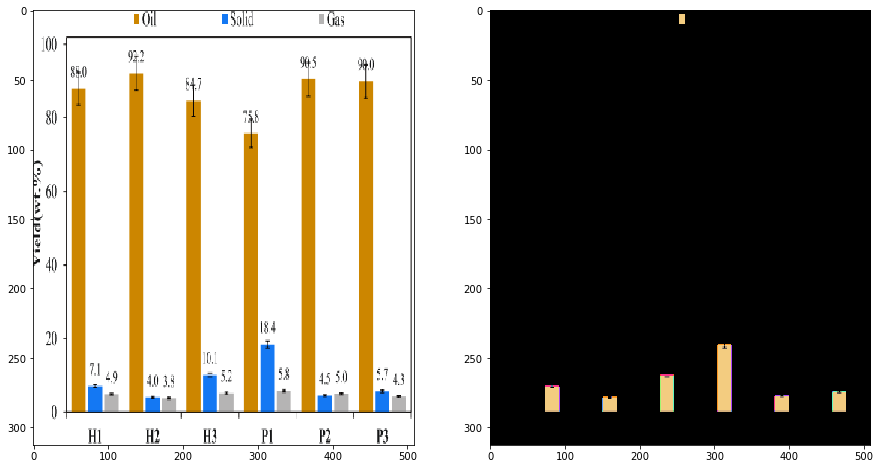

In [5]:
img = cv2.imread('test/test2.png')

BLUE_MIN = np.array([5, 50, 50], np.uint8)
BLUE_MAX = np.array([15, 255, 255], np.uint8)

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_img, BLUE_MIN, BLUE_MAX)
mask_img = cv2.bitwise_and(img, img, mask = mask)
image = cv2.cvtColor(mask_img, cv2.COLOR_HSV2RGB)

rcParams['figure.figsize'] = 15, 8

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, aspect = 'auto')
ax[1].imshow(image, aspect = 'auto')

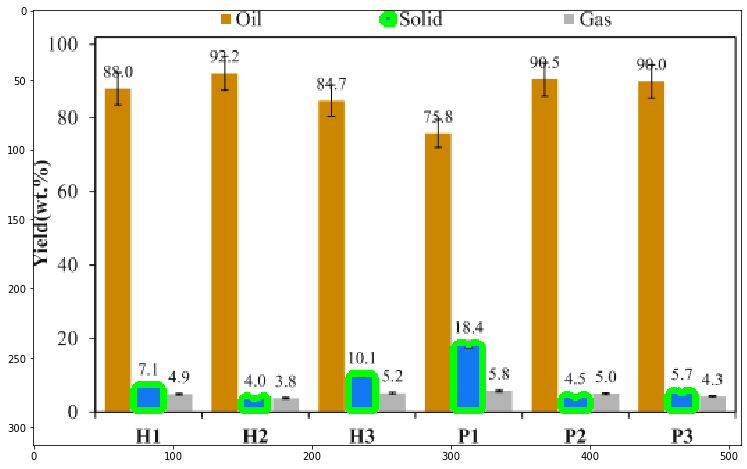

In [6]:
edged = cv2.Canny(image, 0, 250)

contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)
plt.imshow(img)

In [7]:
rects = [cv2.boundingRect(cnt) for cnt in contours]

In [8]:
# Get the nearest non-overlapping bounding box
# for each of this contour bounding box.

def euclidean(v1, v2):
    return sum((p - q) ** 2 for p, q in zip(v1, v2)) ** .5

def RectDist(rectA, rectB):
    (rectAx, rectAy, rectAw, rectAh) = rectA
    (rectBx, rectBy, rectBw, rectBh) = rectB
    
    return euclidean([rectAx + rectAw / 2, rectAy + rectAh / 2], [rectBx + rectBw / 2, rectBy + rectBh / 2])

textBoxes = []

for rectBox in rects:
    min_distance = sys.maxsize
    closestBox = None
    
    for text, textBox in texts[1]:       
        if RectDist(rectBox, textBox) < min_distance:
            closestBox = textBox
            min_distance = RectDist(rectBox, textBox)
      
    if closestBox is not None:
        textBoxes.append(closestBox)

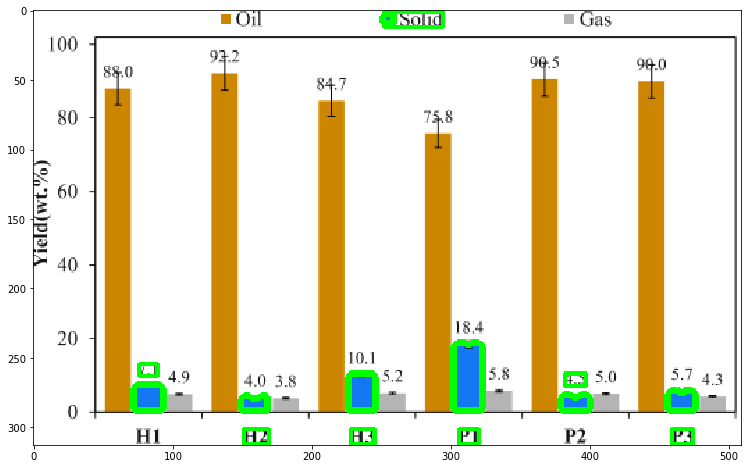

In [9]:
for box in textBoxes:
    (x, y, w, h) = box
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plt.imshow(img)